In [1]:
import lsst.afw.image as afwImage
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from astropy.io import ascii

In [2]:
path = "/sdf/data/rubin/repo/main/DECam/communityProcessed/dr2_tiles/DES2359-6539/DES2359-6539_r4907p01_g.fits.fz"

In [3]:
exp = afwImage.ExposureF
w = exp.readFits(path)

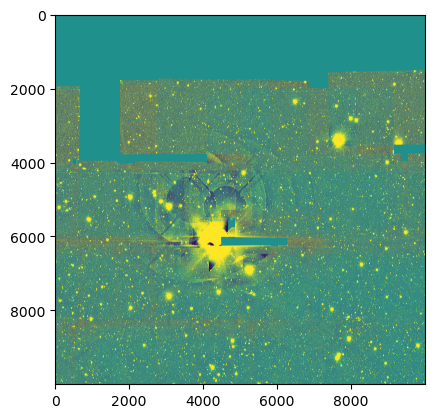

In [4]:
plt.imshow(w.image.array,vmin=-5,vmax=5)
plt.show()

In [5]:
w.getMetadata()

TTYPE1 = "COMPRESSED_DATA"
// label for field   1
TFORM1 = "1PB(8522)"
// data format of field: variable length array
TTYPE2 = "ZSCALE"
// label for field   2
TFORM2 = "1D"
// data format of field: 8-byte DOUBLE
TTYPE3 = "ZZERO"
// label for field   3
TFORM3 = "1D"
// data format of field: 8-byte DOUBLE
EXTNAME = "SCI"
GAIN = 31.277318886860
// Maximum equivalent gain (e-/ADU)
SATURATE = 33373.351522610
// Saturation Level (ADU)
SOFTNAME = "SWarp"
// The software that processed those data
SOFTVERS = "2.40.1"
// Version of the software
SOFTDATE = "2019-02-05"
// Release date of the software
SOFTAUTH = "2010-2012 IAP/CNRS/UPMC"
// Maintainer of the software
SOFTINST = "IAP  http://www.iap.fr"
// Institute
AUTHOR = "unknown"
// Who ran the software
ORIGIN = "ccc0022.campuscluster.illinois.edu"
// Where it was done
DATE = "2019-06-27T04:55:38"
// When it was started (GMT)
COMBINET = "WEIGHTED"
// COMBINE_TYPE config parameter for SWarp
BUNIT = "COUNTS/S"
// units of pixels
FILTER = "g DECa

## Butler command to ingest files

In [6]:
import lsst.daf.butler as daf_butler
from astropy.coordinates import SkyCoord
from astropy import units as u
import lsst.geom as geom
import os
import astropy.table as table

In [7]:
but = daf_butler.Butler("/repo/main")

In [8]:
but.registry.queryDatasetTypes("template_coadd")

[DatasetType('template_coadd', {band, skymap, tract, patch}, ExposureF)]

In [9]:
REPO = "/repo/main"
DATASET_TYPE = "template_coadd"
RUN = "dr2_bkg"
TABLE_FILE = "tableFile"

In [10]:
tab = table.Table()
skymaps = but.registry.queryDatasets("skyMap",collections='DECam/defaults')
decamSkymap_ringsv1 = list(skymaps)[2]
result = but.get(decamSkymap_ringsv1)

In [110]:
baseDir = "/sdf/group/rubin/repo/main/DECam/communityProcessed/dr2_tiles"

dataArr = []

for subDir in np.sort(os.listdir(baseDir))[1:]:
    
    subDirFiles = os.listdir(os.path.join(baseDir,subDir))
    
    msk = [(x.endswith(".fits.fz") and not (x.__contains__("nobkg") or x.__contains__("det"))) for x in subDirFiles]
    # msk = [(x.endswith(".fits.fz") and x.__contains__("nobkg") and not x.__contains__("det")) for x in subDirFiles]
    
    filteredFiles = np.array(subDirFiles)[msk]
    
    ra, dec = filteredFiles[0][0:12][3:7],filteredFiles[0][0:12][7:] # The hhmm and ddmm form of ra and dec
    
    ra_h = int(ra[0:2]) # string stripping
    ra_m = int(ra[2:])
    dec_deg = int(dec[1:3])
    dec_m = int(dec[3:])
    offset = dec[0] # computing if dec is +/- the equator
    
    finalRa = (ra_h*15+ra_m/60)*u.deg # final RA
    
    if offset=="-": # final DEC
        finalDec = -1 * (dec_deg+dec_m/60)*u.deg
    else: 
        finalDec = (dec_deg+dec_m/60)*u.deg
    
    coord=SkyCoord(finalRa,finalDec,frame="icrs")

    tractInf,patchInf = result.findClosestTractPatchList([geom.SpherePoint(geom.Angle(coord.ra.deg/(180/np.pi)),geom.Angle(coord.dec.deg/(180/np.pi)))])[0]
    
    for file in filteredFiles:
        fullFname = os.path.join(baseDir,subDir,file)
        
        band = str(fullFname.split(".")[0][-1]).lower()
        # band = fullFname.split("_")[-2].lower()
        
        dataArr.append([fullFname,band,str(decamSkymap_ringsv1.dataId["skymap"]),tractInf.getId(),patchInf[0].getSequentialIndex()])

In [111]:
df = pd.DataFrame(np.array(dataArr),columns=["filename","band","skymap","tract","patch"])
band_tract_patch = df["band"]+"_"+df["tract"]+"_"+df['patch']
uniq_band_tract_patch,indices,counts = np.unique(band_tract_patch,return_index=True,return_counts=True)
df.iloc[indices].to_csv("tableFile_bkg.csv",index=False,header=True)

In [112]:
table = ascii.read("tableFile_bkg.csv")

## Now, what command should be entered to ingest this data?

In [89]:
band = fullFname.split(".")[0][-1]

In [90]:
but.registry.queryDatasetTypes("raw")[0]

DatasetType('raw', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure)

In [91]:
reg = but.registry

In [113]:
b=list(reg.queryDatasets("raw",collections=["DECam/defaults"],where="band='y'"))

In [95]:
b[0:100]

[DatasetRef(DatasetType('raw', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'DECam', detector: 1, exposure: 155051, band: 'y', day_obs: 20121123, group: '155051', physical_filter: 'Y DECam c0005 10095.0 1130.0'}, run='DECam/raw/all', id=2c37a677-7bc6-5eea-8a63-0ccfeec932b8),
 DatasetRef(DatasetType('raw', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'DECam', detector: 1, exposure: 155052, band: 'y', day_obs: 20121123, group: '155052', physical_filter: 'Y DECam c0005 10095.0 1130.0'}, run='DECam/raw/all', id=43ff0816-13ad-59ba-9267-ad7ae1dbe69d),
 DatasetRef(DatasetType('raw', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'DECam', detector: 1, exposure: 155053, band: 'y', day_obs: 20121123, group: '155053', physical_filter: 'Y DECam c0005 10095.0 1130.0'}, run='DECam/raw/all', id=de100258-16e1-5ddf-bcd6-a665aad50d5b),
 DatasetRef(Data

In [98]:
"Y".lower()

'y'

In [102]:
but.registry.queryDatasetTypes("template_coadd")

[DatasetType('template_coadd', {band, skymap, tract, patch}, ExposureF)]

In [114]:
list(but.registry.queryDatasets("template_coadd",collections="DECam/DES/dr2_bkg"))

[DatasetRef(DatasetType('template_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'decam_rings_v1', tract: 1002, patch: 15}, run='DECam/DES/dr2_bkg', id=811aa82c-c9b4-43af-9faf-951d28a5f63c),
 DatasetRef(DatasetType('template_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'decam_rings_v1', tract: 1002, patch: 16}, run='DECam/DES/dr2_bkg', id=c4558ba6-b1d0-4d48-b990-8e1d90cc00b9),
 DatasetRef(DatasetType('template_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'decam_rings_v1', tract: 1002, patch: 17}, run='DECam/DES/dr2_bkg', id=2b52bada-264b-4448-a85b-9560fb8d7998),
 DatasetRef(DatasetType('template_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'decam_rings_v1', tract: 1002, patch: 27}, run='DECam/DES/dr2_bkg', id=93c35b15-10cd-4f14-a40f-dce4af8085df),
 DatasetRef(DatasetType('template_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'decam_rings_v1', tract: 1002, patch: 28